In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import schedulefree

import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("../auto_LiRPA/")
import auto_LiRPA
from auto_LiRPA.operators.gurobi_maxpool_lp import compute_maxpool_bias

Since solving a series of linear programs for every unstable MaxPool neuron takes a prohibitive amount of time, we want to learn a neural network to approximate the optimal value of the series of linear programs.

Subsequently, we want to verify that network, so it can be used instead of the LPs.

# Idea

To allow the NN to learn the LP solutions for globally valid parameters of
- lower bounds
- upper bounds and
- slope values

we **normalize the bounds** to $[0,1]$, s.t. the smallest lower bound gets mapped to $0$ and the largest upper bound gets mapped to $1$.
Similarly, we restrict the allowable slope values to $[0,1]$ (**TODO**: Show that this is sufficient for MaxPool).

## 2x2 MaxPool

We start with the easier case of lower dimensional MaxPool neurons.

In [8]:
# (batch, channels, w, h), we only look at a single neuron for now
l = torch.randn(1, 1, 2, 2)
u = torch.abs(torch.randn(1, 1, 2, 2)) + l
alpha = torch.rand(1, 1, 2, 2)

print("l = ", l)
print("u = ", u)

l =  tensor([[[[ 0.3786, -0.1183],
          [-0.6204,  0.1453]]]])
u =  tensor([[[[ 0.9778,  0.7224],
          [-0.2365,  2.6166]]]])


In [9]:
compute_maxpool_bias(l, u, alpha)

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


tensor([[0.9637]])

In [10]:
# now for a lot of neurons
n_neurons = 100
l = torch.randn(n_neurons, 1, 2, 2)
u = torch.abs(torch.randn(n_neurons, 1, 2, 2)) + l
alpha = torch.rand(n_neurons, 1, 2, 2)

biases = compute_maxpool_bias(l, u, alpha)

100%|██████████| 100/100 [00:00<00:00, 188.14it/s]


In [40]:
lmin = l.flatten(-2).min(dim=-1)[0]
umax = u.flatten(-2).max(dim=-1)[0]

lmin = lmin.unsqueeze(1)
umax = umax.unsqueeze(1)

In [49]:
l_norm = (l.flatten(-2) - lmin) / (umax - lmin)
u_norm = (u.flatten(-2) - lmin) / (umax - lmin)
l_norm = l_norm.view(l.shape)
u_norm = u_norm.view(u.shape)

In [51]:
biases_norm = compute_maxpool_bias(l_norm, u_norm, alpha)

100%|██████████| 100/100 [00:00<00:00, 207.94it/s]


In [68]:
biases_unnorm = biases_norm.unsqueeze(1) * (umax - lmin) - (alpha.flatten(-2).sum(dim=-1) - 1).unsqueeze(1) * lmin
biases_unnorm = biases_unnorm.squeeze(1)

The error falls within the `float32` range.

So normalization seems to work :-)

In [70]:
torch.max(torch.abs(biases_unnorm - biases))

tensor(9.5367e-07)

## Normalization: Now in a Single Method

In [73]:
def normalize_bounds(l, u):
    """
    Takes bounds tensors and normalizes them to [0, 1], s.t. smallest lower bound is mapped to 0
    and largest upper bound is mapped to 1

    args:
        l (batch x channels x w x h) - concrete lower bounds
        u (batch x channels x w x h) - concrete upper bounds

    returns:
        l_norm (batch x channels x w x h) - normalized concrete lower bounds
        u_norm (batch x channels x w x h) - normalized concrete upper bounds
    """
    lmin = l.flatten(-2).min(dim=-1)[0]
    umax = u.flatten(-2).max(dim=-1)[0]
    lmin = lmin.unsqueeze(1)
    umax = umax.unsqueeze(1)

    l_norm = (l.flatten(-2) - lmin) / (umax - lmin)
    u_norm = (u.flatten(-2) - lmin) / (umax - lmin)
    l_norm = l_norm.view(l.shape)
    u_norm = u_norm.view(u.shape)

    return l_norm, u_norm

In [76]:
def denormalize_bias(l, u, alpha, bias):
    """ 
    Converts biases obtained from the normalized problem to the biases for the unnormalized problem.

    args:
        l (batch x channels x w x h) - unnormalized concrete lower bounds
        u (batch x channels x w x h) - unnormalized concrete upper bounds
        alpha (batch x channels x w x h) - slope values
        bias (batch x channels) - normalized bias values

    returns:
        bias_unnorm (batch x channels) - biases for unnormalized problem
    """
    lmin = l.flatten(-2).min(dim=-1)[0]
    umax = u.flatten(-2).max(dim=-1)[0]
    lmin = lmin.unsqueeze(1)
    umax = umax.unsqueeze(1)

    biases_unnorm = bias.unsqueeze(1) * (umax - lmin) - (alpha.flatten(-2).sum(dim=-1) - 1).unsqueeze(1) * lmin
    biases_unnorm = biases_unnorm.squeeze(1)

    return biases_unnorm

## Create Dataset

In [81]:
def create_dataset(n_neurons, h, w):
    # since the normalized version suffices, just stick to that
    x1 = torch.rand(n_neurons, 1, h, w)
    x2 = torch.rand(n_neurons, 1, h, w)

    l = torch.where(x1 <= x2, x1, x2)
    u = torch.where(x1  > x2, x1, x2)

    alpha = torch.rand(n_neurons, 1, h, w)

    biases = compute_maxpool_bias(l, u, alpha)

    return l, u, alpha, biases

In [100]:
def create_tensor_dataset(n_neurons_train, n_neurons_val, h, w):
    l, u, alpha, bias = create_dataset(n_neurons_train, h, w)
    X = torch.cat((l, u, alpha), dim=1)
    dataset_train = TensorDataset(X, bias)

    l, u, alpha, bias = create_dataset(n_neurons_val, h, w)
    X = torch.cat((l, u, alpha), dim=1)
    dataset_val = TensorDataset(X, bias)

    return dataset_train, dataset_val

In [137]:
batch_size = 32
n_train = 50000
n_val = 5000

ds_train, ds_val = create_tensor_dataset(n_train, n_val, 2, 2)
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(ds_val, batch_size=batch_size)

100%|██████████| 5000/5000 [00:32<00:00, 155.86it/s]


In [163]:
def train_loop(net, train_dataloader, val_dataloader, patience=10, num_epochs=100, lossfun='mse', opt='adam'):
    if lossfun == 'mse':
        criterion = nn.MSELoss()
    elif lossfun == 'mae':
        criterion = nn.L1Loss()
    else:
        raise ValueError('Unknown loss function!')
    
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters())
    elif opt == 'schedulefree':
        optimizer = schedulefree.AdamWScheduleFree(net.parameters(), lr=0.0025)
    else:
        raise ValueError('Uknown optimizer!')


    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    best_val_loss = float('inf')
    early_stopping_cnt = 0
    for epoch in range(num_epochs):
        net.train()

        if opt == 'schedulefree':
            optimizer.train()

        train_loss = 0.
        train_mae = 0.
        for batch_X, batch_y in train_dataloader:
            y_hat = net(batch_X)
            loss = criterion(y_hat, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(y_hat - batch_y).mean().item()

        train_loss /= len(train_dataloader)
        train_mae /= len(train_dataloader)
        train_losses.append(train_loss)
        train_maes.append(train_mae)


        net.eval()

        if opt == 'schedulefree':
            optimizer.eval()
            
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for batch_X, batch_y in val_dataloader:
                y_hat = net(batch_X)
                loss = criterion(y_hat, batch_y)
                val_loss += loss.item()
                val_mae += torch.abs(y_hat - batch_y).mean().item()

        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_mae: {train_mae:.4f}, val_mae: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_cnt = 0
            best_net_state = net.state_dict()
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= patience:
                print("Stopping early (patience of {patience} reached)")
                break


    print("Training completed")
    return train_losses, val_losses, train_maes, val_maes, best_net_state

In [131]:
net1x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))

In [138]:
train_losses1x30, val_losses1x30, train_maes1x30, val_maes1x30, best_state1x30 = train_loop(net1x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0024, val_loss: 0.0027, train_mae: 0.0390, val_mae: 0.0414
Epoch [2/1000] - train_loss: 0.0024, val_loss: 0.0024, train_mae: 0.0383, val_mae: 0.0386
Epoch [3/1000] - train_loss: 0.0024, val_loss: 0.0023, train_mae: 0.0382, val_mae: 0.0376
Epoch [4/1000] - train_loss: 0.0023, val_loss: 0.0023, train_mae: 0.0376, val_mae: 0.0376
Epoch [5/1000] - train_loss: 0.0023, val_loss: 0.0023, train_mae: 0.0377, val_mae: 0.0379
Epoch [6/1000] - train_loss: 0.0023, val_loss: 0.0022, train_mae: 0.0374, val_mae: 0.0364
Epoch [7/1000] - train_loss: 0.0022, val_loss: 0.0022, train_mae: 0.0372, val_mae: 0.0364
Epoch [8/1000] - train_loss: 0.0022, val_loss: 0.0023, train_mae: 0.0371, val_mae: 0.0372
Epoch [9/1000] - train_loss: 0.0022, val_loss: 0.0022, train_mae: 0.0370, val_mae: 0.0368
Epoch [10/1000] - train_loss: 0.0022, val_loss: 0.0024, train_mae: 0.0366, val_mae: 0.0389
Epoch [11/1000] - train_loss: 0.0021, val_loss: 0.0022, train_mae: 0.0363, val_mae: 0.0366
Epoch [1

In [139]:
train_losses2x30, val_losses2x30, train_maes2x30, val_maes2x30, best_state2x30 = train_loop(net2x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0249
Epoch [2/1000] - train_loss: 0.0010, val_loss: 0.0015, train_mae: 0.0249, val_mae: 0.0313
Epoch [3/1000] - train_loss: 0.0010, val_loss: 0.0009, train_mae: 0.0243, val_mae: 0.0237
Epoch [4/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0240, val_mae: 0.0246
Epoch [5/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0238, val_mae: 0.0248
Epoch [6/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0237, val_mae: 0.0228
Epoch [7/1000] - train_loss: 0.0009, val_loss: 0.0008, train_mae: 0.0230, val_mae: 0.0220
Epoch [8/1000] - train_loss: 0.0009, val_loss: 0.0010, train_mae: 0.0229, val_mae: 0.0252
Epoch [9/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0228, val_mae: 0.0214
Epoch [10/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0227, val_mae: 0.0218
Epoch [11/1000] - train_loss: 0.0008, val_loss: 0.0008, train_mae: 0.0225, val_mae: 0.0220
Epoch [1

In [140]:
train_losses3x30, val_losses3x30, train_maes3x30, val_maes3x30, best_state3x30 = train_loop(net3x30, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0012, val_loss: 0.0013, train_mae: 0.0273, val_mae: 0.0287
Epoch [2/1000] - train_loss: 0.0012, val_loss: 0.0012, train_mae: 0.0268, val_mae: 0.0269
Epoch [3/1000] - train_loss: 0.0011, val_loss: 0.0011, train_mae: 0.0262, val_mae: 0.0261
Epoch [4/1000] - train_loss: 0.0011, val_loss: 0.0010, train_mae: 0.0262, val_mae: 0.0245
Epoch [5/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0251
Epoch [6/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0252, val_mae: 0.0241
Epoch [7/1000] - train_loss: 0.0010, val_loss: 0.0010, train_mae: 0.0247, val_mae: 0.0240
Epoch [8/1000] - train_loss: 0.0010, val_loss: 0.0012, train_mae: 0.0245, val_mae: 0.0266
Epoch [9/1000] - train_loss: 0.0010, val_loss: 0.0009, train_mae: 0.0244, val_mae: 0.0235
Epoch [10/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0238, val_mae: 0.0228
Epoch [11/1000] - train_loss: 0.0009, val_loss: 0.0012, train_mae: 0.0237, val_mae: 0.0285
Epoch [1

In [148]:
net6x50 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))

In [149]:
train_losses6x50, val_losses6x50, train_maes6x50, val_maes6x50, best_state6x50 = train_loop(net6x50, train_dataloader, val_dataloader, patience=50, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0123, val_loss: 0.0032, train_mae: 0.0737, val_mae: 0.0450
Epoch [2/1000] - train_loss: 0.0029, val_loss: 0.0029, train_mae: 0.0425, val_mae: 0.0423
Epoch [3/1000] - train_loss: 0.0022, val_loss: 0.0020, train_mae: 0.0372, val_mae: 0.0359
Epoch [4/1000] - train_loss: 0.0018, val_loss: 0.0018, train_mae: 0.0328, val_mae: 0.0335
Epoch [5/1000] - train_loss: 0.0015, val_loss: 0.0012, train_mae: 0.0304, val_mae: 0.0266
Epoch [6/1000] - train_loss: 0.0013, val_loss: 0.0012, train_mae: 0.0286, val_mae: 0.0279
Epoch [7/1000] - train_loss: 0.0012, val_loss: 0.0011, train_mae: 0.0269, val_mae: 0.0262
Epoch [8/1000] - train_loss: 0.0011, val_loss: 0.0009, train_mae: 0.0255, val_mae: 0.0241
Epoch [9/1000] - train_loss: 0.0010, val_loss: 0.0014, train_mae: 0.0246, val_mae: 0.0302
Epoch [10/1000] - train_loss: 0.0009, val_loss: 0.0009, train_mae: 0.0237, val_mae: 0.0242
Epoch [11/1000] - train_loss: 0.0009, val_loss: 0.0008, train_mae: 0.0233, val_mae: 0.0223
Epoch [1

In [164]:
net6x50mae = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))

In [165]:
train_losses6x50mae, val_losses6x50mae, train_maes6x50mae, val_maes6x50mae, best_state6x50mae = train_loop(net6x50mae, train_dataloader, val_dataloader, patience=50, num_epochs=1000, lossfun='mae')

Epoch [1/1000] - train_loss: 0.0779, val_loss: 0.0554, train_mae: 0.0779, val_mae: 0.0554
Epoch [2/1000] - train_loss: 0.0441, val_loss: 0.0393, train_mae: 0.0441, val_mae: 0.0393
Epoch [3/1000] - train_loss: 0.0385, val_loss: 0.0406, train_mae: 0.0385, val_mae: 0.0406
Epoch [4/1000] - train_loss: 0.0346, val_loss: 0.0305, train_mae: 0.0346, val_mae: 0.0305
Epoch [5/1000] - train_loss: 0.0324, val_loss: 0.0321, train_mae: 0.0324, val_mae: 0.0321
Epoch [6/1000] - train_loss: 0.0301, val_loss: 0.0272, train_mae: 0.0301, val_mae: 0.0272
Epoch [7/1000] - train_loss: 0.0282, val_loss: 0.0284, train_mae: 0.0282, val_mae: 0.0284
Epoch [8/1000] - train_loss: 0.0269, val_loss: 0.0291, train_mae: 0.0269, val_mae: 0.0291
Epoch [9/1000] - train_loss: 0.0257, val_loss: 0.0245, train_mae: 0.0257, val_mae: 0.0245
Epoch [10/1000] - train_loss: 0.0251, val_loss: 0.0246, train_mae: 0.0251, val_mae: 0.0246
Epoch [11/1000] - train_loss: 0.0239, val_loss: 0.0228, train_mae: 0.0239, val_mae: 0.0228
Epoch [1

In [166]:
net1x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net6x50 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net_large = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

net1x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), 
                              torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net6x50sf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net_largesf = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

In [167]:
nets = [net_large, net1x30sf, net2x30sf, net3x30sf, net6x50sf, net_largesf]

train_losses_list = []
val_losses_list = []
train_maes_list = []
val_maes_list = []
best_states_list = []

for i, net in enumerate(nets):
    if i == 1:
        opt = 'adam'
    else:
        opt = 'schedulefree'

    train_losses, val_losses, train_maes, val_maes, best_state = train_loop(net, train_dataloader, val_dataloader, patience=50, num_epochs=1000, opt=opt)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_maes_list.append(train_maes)
    val_maes_list.append(val_maes)
    best_states_list.append(best_state)

Epoch [1/1000] - train_loss: 0.0049, val_loss: 0.0009, train_mae: 0.0471, val_mae: 0.0238
Epoch [2/1000] - train_loss: 0.0008, val_loss: 0.0004, train_mae: 0.0223, val_mae: 0.0158
Epoch [3/1000] - train_loss: 0.0006, val_loss: 0.0003, train_mae: 0.0180, val_mae: 0.0120
Epoch [4/1000] - train_loss: 0.0004, val_loss: 0.0002, train_mae: 0.0148, val_mae: 0.0100
Epoch [5/1000] - train_loss: 0.0003, val_loss: 0.0001, train_mae: 0.0135, val_mae: 0.0088
Epoch [6/1000] - train_loss: 0.0003, val_loss: 0.0001, train_mae: 0.0118, val_mae: 0.0081
Epoch [7/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0115, val_mae: 0.0076
Epoch [8/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0100, val_mae: 0.0071
Epoch [9/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0098, val_mae: 0.0068
Epoch [10/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0093, val_mae: 0.0066
Epoch [11/1000] - train_loss: 0.0002, val_loss: 0.0001, train_mae: 0.0091, val_mae: 0.0063
Epoch [1

In [172]:
net_largesf2 = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))

In [173]:
train_losses_large2, val_losses_large2, train_maes_large2, val_maes_large2, best_state_large2 = train_loop(net_largesf2, train_dataloader, val_dataloader, patience=200, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0060, val_loss: 0.0015, train_mae: 0.0519, val_mae: 0.0308
Epoch [2/1000] - train_loss: 0.0012, val_loss: 0.0013, train_mae: 0.0269, val_mae: 0.0285
Epoch [3/1000] - train_loss: 0.0008, val_loss: 0.0007, train_mae: 0.0216, val_mae: 0.0211
Epoch [4/1000] - train_loss: 0.0006, val_loss: 0.0004, train_mae: 0.0188, val_mae: 0.0162
Epoch [5/1000] - train_loss: 0.0005, val_loss: 0.0005, train_mae: 0.0168, val_mae: 0.0170
Epoch [6/1000] - train_loss: 0.0004, val_loss: 0.0003, train_mae: 0.0160, val_mae: 0.0130
Epoch [7/1000] - train_loss: 0.0004, val_loss: 0.0003, train_mae: 0.0145, val_mae: 0.0123
Epoch [8/1000] - train_loss: 0.0003, val_loss: 0.0005, train_mae: 0.0138, val_mae: 0.0183
Epoch [9/1000] - train_loss: 0.0003, val_loss: 0.0002, train_mae: 0.0134, val_mae: 0.0106
Epoch [10/1000] - train_loss: 0.0002, val_loss: 0.0002, train_mae: 0.0121, val_mae: 0.0116
Epoch [11/1000] - train_loss: 0.0003, val_loss: 0.0003, train_mae: 0.0125, val_mae: 0.0139
Epoch [1

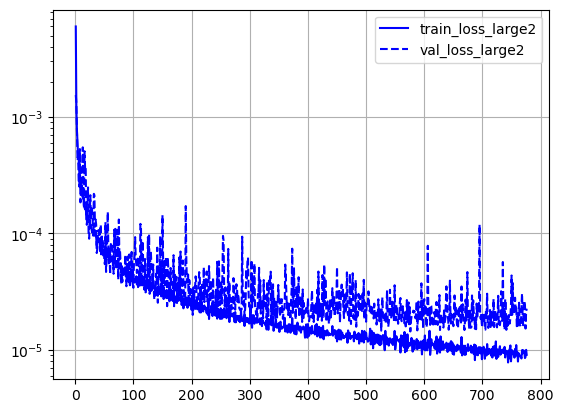

In [174]:
num_epochs_large2 = len(train_losses_large2)

plt.plot(range(1, num_epochs_large2+1), train_losses_large2, label="train_loss_large2", color='blue')
plt.plot(range(1, num_epochs_large2+1), val_losses_large2, label="val_loss_large2", color='blue', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

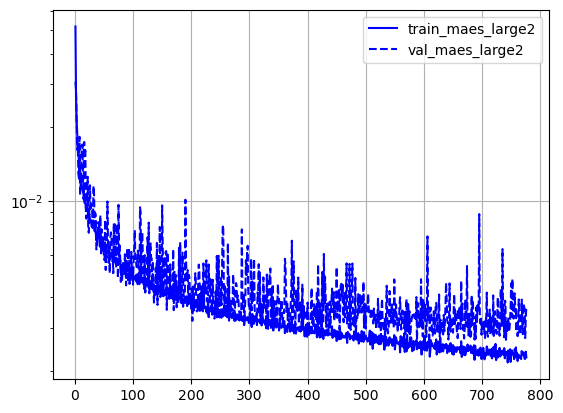

In [175]:
num_epochs_large2 = len(train_losses_large2)

plt.plot(range(1, num_epochs_large2+1), train_maes_large2, label="train_maes_large2", color='blue')
plt.plot(range(1, num_epochs_large2+1), val_maes_large2, label="val_maes_large2", color='blue', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

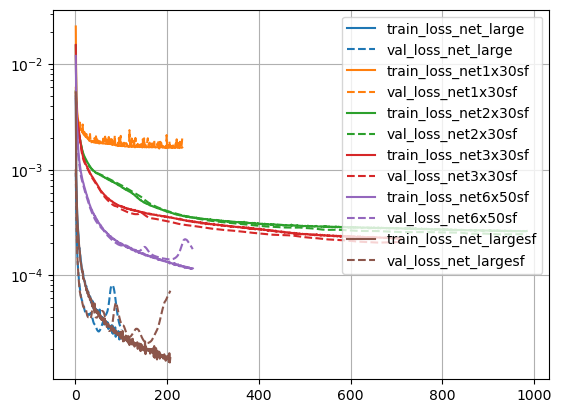

In [169]:
netnames = ['net_large', 'net1x30sf', 'net2x30sf', 'net3x30sf', 'net6x50sf', 'net_largesf']
for i, (netname, tl, vl) in enumerate(zip(netnames, train_losses_list, val_losses_list)):
    num_epochs = len(tl)
    color = f"C{i}"
    plt.plot(range(1, num_epochs+1), tl, label=f"train_loss_{netname}", color=color)
    plt.plot(range(1, num_epochs+1), vl, label=f"val_loss_{netname}", color=color, linestyle='--')


plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

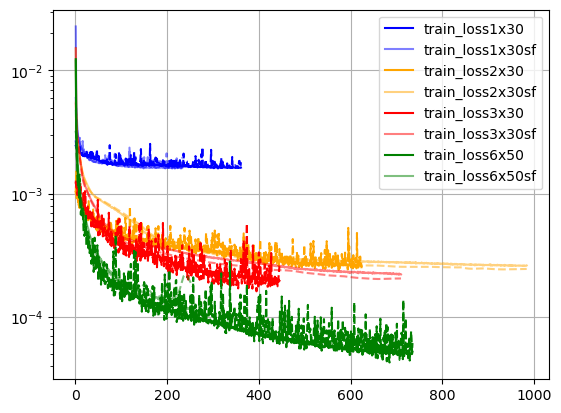

In [197]:
num_epochs1x30 = len(train_losses1x30)
num_epochs2x30 = len(train_losses2x30)
num_epochs3x30 = len(train_losses3x30)
num_epochs6x50 = len(train_losses6x50)

num_epochs1x30sf = len(train_losses_list[1])
num_epochs2x30sf = len(train_losses_list[2])
num_epochs3x30sf = len(train_losses_list[3])
num_epochs6x50sf = len(train_losses_list[4])

plt.plot(range(1, num_epochs1x30+1), train_losses1x30, label="train_loss1x30", color='blue')
plt.plot(range(1, num_epochs1x30+1), val_losses1x30, color='blue', linestyle='--')
plt.plot(range(1, num_epochs1x30sf+1), train_losses_list[1], label="train_loss1x30sf", color='blue', alpha=0.5)
plt.plot(range(1, num_epochs1x30sf+1), val_losses_list[1], color='blue', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs2x30+1), train_losses2x30, label="train_loss2x30", color='orange')
plt.plot(range(1, num_epochs2x30+1), val_losses2x30, color='orange', linestyle='--')
plt.plot(range(1, num_epochs2x30sf+1), train_losses_list[2], label="train_loss2x30sf", color='orange', alpha=0.5)
plt.plot(range(1, num_epochs2x30sf+1), val_losses_list[2], color='orange', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs3x30+1), train_losses3x30, label="train_loss3x30", color='red')
plt.plot(range(1, num_epochs3x30+1), val_losses3x30, color='red', linestyle='--')
plt.plot(range(1, num_epochs3x30sf+1), train_losses_list[3], label="train_loss3x30sf", color='red', alpha=0.5)
plt.plot(range(1, num_epochs3x30sf+1), val_losses_list[3], color='red', linestyle='--', alpha=0.5)

plt.plot(range(1, num_epochs6x50+1), train_losses6x50, label="train_loss6x50", color='green')
plt.plot(range(1, num_epochs6x50+1), val_losses6x50, color='green', linestyle='--')
plt.plot(range(1, num_epochs6x50sf+1), train_losses_list[4], label="train_loss6x50sf", color='green', alpha=0.5)
plt.plot(range(1, num_epochs6x50sf+1), val_losses_list[4], color='green', linestyle='--', alpha=0.5)

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

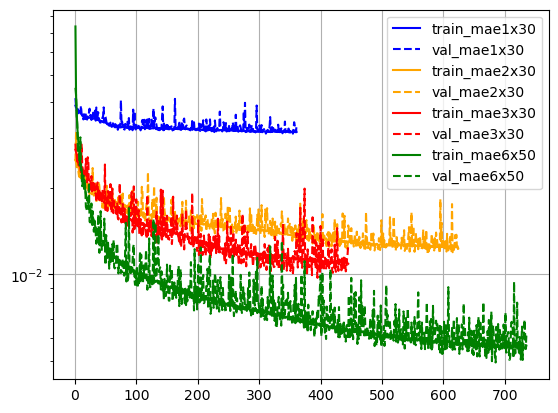

In [154]:
plt.plot(range(1, num_epochs1x30+1), train_maes1x30, label="train_mae1x30", color='blue')
plt.plot(range(1, num_epochs1x30+1), val_maes1x30, label="val_mae1x30", color='blue', linestyle='--')

plt.plot(range(1, num_epochs2x30+1), train_maes2x30, label="train_mae2x30", color='orange')
plt.plot(range(1, num_epochs2x30+1), val_maes2x30, label="val_mae2x30", color='orange', linestyle='--')

plt.plot(range(1, num_epochs3x30+1), train_maes3x30, label="train_mae3x30", color='red')
plt.plot(range(1, num_epochs3x30+1), val_maes3x30, label="val_mae3x30", color='red', linestyle='--')

plt.plot(range(1, num_epochs6x50+1), train_maes6x50, label="train_mae6x50", color='green')
plt.plot(range(1, num_epochs6x50+1), val_maes6x50, label="val_mae6x50", color='green', linestyle='--')

plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

# Error Histograms

In [188]:
"""
Computes the difference y_true - y_hat for every sample in the given dataset

args:
    net - neural network
    dloader - data loader for the dataset
"""
def loss_histogram_data(net, dloader):
    all_diffs = []
    with torch.no_grad():
        for batch_X, batch_y in dloader:
            y_hat = net(batch_X)
            all_diffs.append(batch_y - y_hat)

    all_diffs = torch.cat(all_diffs).view(-1).numpy()
    return all_diffs

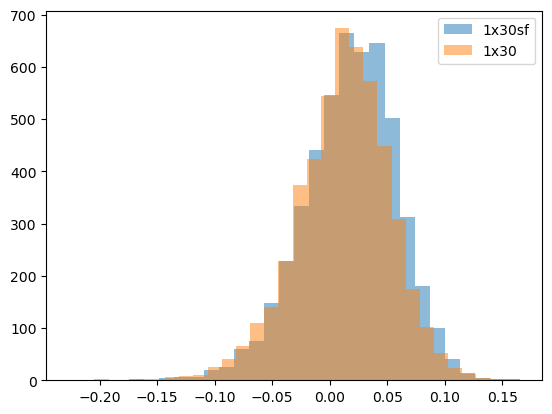

In [215]:
net1x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net1x30_best.load_state_dict(best_state1x30)

net1x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net1x30sf_best.load_state_dict(best_states_list[1])

diffs_1x30sf = loss_histogram_data(net1x30sf_best, val_dataloader)
diffs_1x30   = loss_histogram_data(net1x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_1x30sf, bins=n_bins, label="1x30sf", alpha=0.5)
plt.hist(diffs_1x30, bins=n_bins, label='1x30', alpha=0.5)
plt.legend()
plt.show()

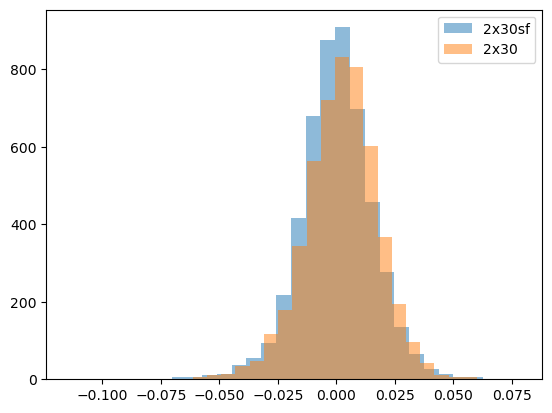

In [205]:
net2x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30_best.load_state_dict(best_state2x30)

net2x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net2x30sf_best.load_state_dict(best_states_list[2])

diffs_2x30sf = loss_histogram_data(net2x30sf_best, val_dataloader)
diffs_2x30   = loss_histogram_data(net2x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_2x30sf, bins=n_bins, label="2x30sf", alpha=0.5)
plt.hist(diffs_2x30, bins=n_bins, label='2x30', alpha=0.5)
plt.legend()
plt.show()

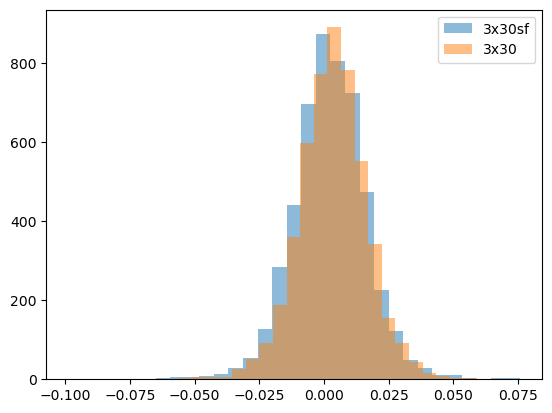

In [207]:
net3x30_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(),  torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30_best.load_state_dict(best_state3x30)

net3x30sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 30), torch.nn.ReLU(), torch.nn.Linear(30, 30), torch.nn.ReLU(),  torch.nn.Linear(30, 30), torch.nn.ReLU(), torch.nn.Linear(30, 1))
net3x30sf_best.load_state_dict(best_states_list[3])

diffs_3x30sf = loss_histogram_data(net3x30sf_best, val_dataloader)
diffs_3x30   = loss_histogram_data(net3x30_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_3x30sf, bins=n_bins, label="3x30sf", alpha=0.5)
plt.hist(diffs_3x30, bins=n_bins, label='3x30', alpha=0.5)
plt.legend()
plt.show()

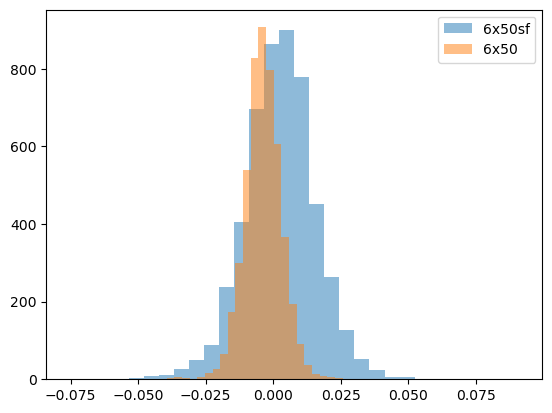

In [208]:
net6x50_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net6x50_best.load_state_dict(best_state6x50)

net6x50sf_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(), 
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 50), torch.nn.ReLU(),
                              torch.nn.Linear(50, 1))
net6x50sf_best.load_state_dict(best_states_list[4])

diffs_6x50sf = loss_histogram_data(net6x50sf_best, val_dataloader)
diffs_6x50   = loss_histogram_data(net6x50_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_6x50sf, bins=n_bins, label="6x50sf", alpha=0.5)
plt.hist(diffs_6x50, bins=n_bins, label='6x50', alpha=0.5)
plt.legend()
plt.show()

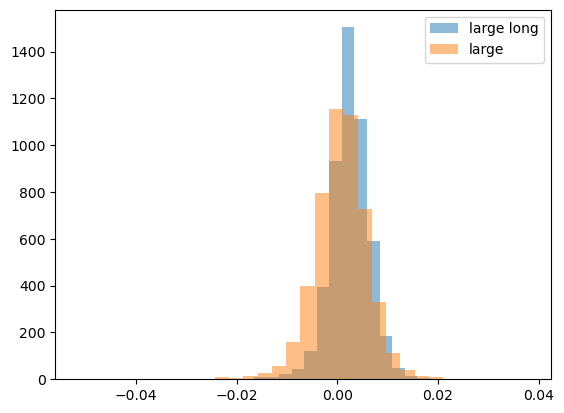

In [209]:
net_large_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large_best.load_state_dict(best_states_list[0])

net_large_long_best = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*2*2, 1000), torch.nn.ReLU(), 
                              torch.nn.Linear(1000, 500), torch.nn.ReLU(), 
                              torch.nn.Linear(500, 250), torch.nn.ReLU(), 
                              torch.nn.Linear(250, 125), torch.nn.ReLU(), 
                              torch.nn.Linear(125, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 30), torch.nn.ReLU(),
                              torch.nn.Linear(30, 1))
net_large_long_best.load_state_dict(best_state_large2)

diffs_large_long = loss_histogram_data(net_large_long_best, val_dataloader)
diffs_large      = loss_histogram_data(net_large_best,   val_dataloader)

n_bins = 30
plt.hist(diffs_large_long, bins=n_bins, label="large long", alpha=0.5)
plt.hist(diffs_large, bins=n_bins, label='large', alpha=0.5)
plt.legend()
plt.show()

# Input Format

Each input consists of a $2\times 2$ tensor of `(l, u, alpha)`.

In the first layer of the neural network, this input is flattened.
I.e. we now have a flat array of `[l1, ..., l4, u1, ..., u4, alpha1, ..., alpha4]`.

In [212]:
ds_train[0][0].shape

torch.Size([3, 2, 2])

In [210]:
ds_train[0]

(tensor([[[0.7138, 0.2893],
          [0.5006, 0.1497]],
 
         [[0.9137, 0.3436],
          [0.7011, 0.7816]],
 
         [[0.5361, 0.0492],
          [0.3276, 0.7446]]]),
 tensor([0.1342]))

In [213]:
ds_train[0][0].flatten()

tensor([0.7138, 0.2893, 0.5006, 0.1497, 0.9137, 0.3436, 0.7011, 0.7816, 0.5361,
        0.0492, 0.3276, 0.7446])

# Export to ONNX

In [216]:
'bla' + 'blubb'

'blablubb'

In [218]:
dummy_input = torch.randn(1, 3, 2, 2)

models = [net1x30sf_best, net2x30sf_best, net6x50_best]
onnx_files = ['net1x30_best.onnx', 'net2x30_best.onnx', 'net6x50_best.onnx']

for model, filename in zip(models, onnx_files):
    torch.onnx.export(model, dummy_input, './models/' + filename, export_params=True, do_constant_folding=True, input_names=['X'], output_names=['Y'])
